Test of NN 

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Keras common configuration
import os
from keras.backend import set_image_dim_ordering

os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32,optimizer=fast_compile'
set_image_dim_ordering('th')

print("Keras user configuration is setup")

Using Theano backend.


Keras user configuration is setup


In [4]:
import theano
print theano.config.device

cpu


In [5]:
from keras.layers import Convolution2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


What happens between image channels when convolution is computed :

- convolution filter is applied on each channel -> we obtain `n_channels` of images
- resulting image is computed as weighted sum of `n_channels` images:

    `out = conv_img[0] * w[0] + conv_img[1] * w[1] + ... conv_img[n_channels] * w[n_channels]`


In [5]:
input_img = np.zeros((100, 100, 4), dtype=np.uint8)
for i in range(1, input_img.shape[2]):
    input_img[:,:,i] = i

input_img[20:40,20:40,:] = 0

0 3


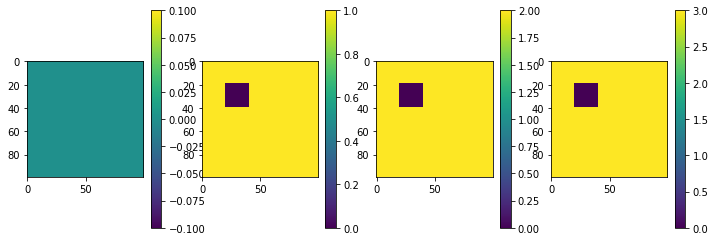

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(input_img[:,:,0])
plt.colorbar()
plt.subplot(142)
plt.imshow(input_img[:,:,1])
plt.colorbar()
plt.subplot(143)
plt.imshow(input_img[:,:,2])
plt.colorbar()
plt.subplot(144)
plt.imshow(input_img[:,:,3])
plt.colorbar()


print input_img.min(), input_img.max()

Number of weights in Convolution2D:
    - n_filters * kernel_width * kernel_height * input_n_channel + n_filters

In [6]:
weights = np.ones((5,4,1,1))
weights[:,0,:,:] = 0
weights[:,1,:,:] = 1
weights[:,2,:,:] = 2
weights[:,3,:,:] = 3
b = np.zeros((5))
model = Sequential()
model.add(Convolution2D(5, 1, 1, input_shape=(4,100,100), weights=[weights, b], border_mode='same', name='conv'))

In [7]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
inputs = input_img.transpose([2,0,1])
output_img = model.predict(inputs[None,:,:,:])

In [9]:
output_img.shape

(1, 5, 100, 100)

In [10]:
conv_layer = model.get_layer('conv')

In [11]:
conv_layer.W.eval().shape, conv_layer.b.eval().shape

((5, 4, 1, 1), (5,))

0.0 14.0


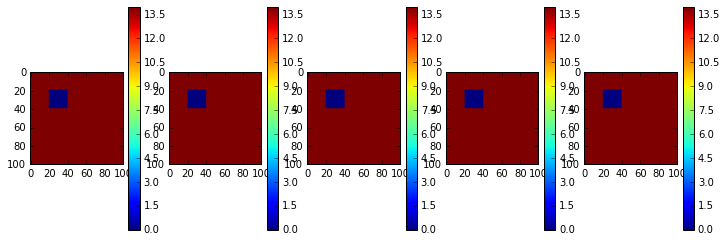

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.imshow(output_img[0,0,:,:])
plt.colorbar()
plt.subplot(152)
plt.imshow(output_img[0,1,:,:])
plt.colorbar()
plt.subplot(153)
plt.imshow(output_img[0,2,:,:])
plt.colorbar()
plt.subplot(154)
plt.imshow(output_img[0,3,:,:])
plt.colorbar()
plt.subplot(155)
plt.imshow(output_img[0,4,:,:])
plt.colorbar()

print output_img.min(), output_img.max()

In [13]:
a = [0, 1, 2, 3]
b = [0, 1, 2, 3]
np.dot(a, b)

14

How to multiply channels ?

$$
O_1 = \sum w_i c_i \cdot \frac{1}{\sum w'_i c_i} + \sum w_i c_i \cdot \sum w'_i c_i
$$

$$
O_2 = \sum w_i c_i \cdot \sum \frac{w'_i}{c_i}
$$

$$
O_3 = \sum w_i c_i + \sum w_i c_i \cdot \sum \frac{w'_i}{c_i} + \sum w_i c_i \cdot \sum w'_i c_i
$$

----

$$
I = \left[ c_0, c_1, ..., c_n \right], \, \text{where} \, c_i \,\text{is a matrix }[h,w]
$$

$$
 C_1 = \left[ C_1(0), C_1(2), ..., C_1(n^1_f) \right], \, \text{where} \, C_1(k) = \sum_i w^k_{1,i} c_i,
$$

$$
 C_2 = \left[ C_2(0), C_2(2), ..., C_2(n^2_f) \right], \, \text{where} \, C_2(k) = \sum_i w^k_{2,i} C_1(i),
$$
$$
C_2(k) = \sum_i w^k_{2,i} \sum_j w^k_{1,j} c_i,
$$



In [1]:
from keras.layers import Input, MaxPooling2D, UpSampling2D, Convolution2D, merge, Reshape, Activation, BatchNormalization
from keras import backend as K
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras.constraints import nonneg, unitnorm, Constraint, maxnorm

Using Theano backend.


In [2]:
import sys
sys.path.append("../common")
from unet import Inverse, ratio, conv, original_termination

Keras user configuration is setup


## Mix channels

In [3]:
def identity(input_layer, **kwargs):
    return input_layer

    
    """
    """
    def __init__(self, m=1, axis=0):
        self.m = m
        self.axis = axis
        
    def __call__(self, p):
        p *= K.cast(p >= 0., K.floatx())
        norms = K.sqrt(K.sum(K.square(p), axis=self.axis, keepdims=True))
        desired = K.clip(norms, 0, self.m)
        p *= (desired / (K.epsilon() + norms))
        return p

    def get_config(self):
        return {'name': self.__class__.__name__,
                'm': self.m,
                'axis': self.axis}


maxnorm_nonneg=MaxNormNonNeg

    
def _conv(input_layer, n_filters_0=16, deep=False, size=3):
    """
    """
    x = Convolution2D(n_filters_0, size, size,
                      activation='relu',
                      init='glorot_uniform',
#                       W_constraint=maxnorm_nonneg(axis=0),
                      W_constraint=maxnorm(axis=0),
                      border_mode='same')(input_layer)
    return x


NameError: name 'MaxNormNonNeg' is not defined

In [4]:
n_filters_0 = 8
n_classes = 2
input_height = 15
input_width = 15
n_channels = 4*3
deep=False

inputs = Input((n_channels, input_height, input_width))
x = inputs

x = conv(x, n_filters_0, size=1, l=0.0)

outputs = original_termination(x, n_classes, input_width, input_height)

model = Model(input=inputs, output=outputs)

NameError: name 'Model' is not defined

In [110]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 12, 15, 15)    0                                            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 8, 15, 15)     104         input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 2, 15, 15)     18          convolution2d_9[0][0]            
Total params: 122
Trainable params: 122
Non-trainable params: 0
____________________________________________________________________________________________________


In [111]:
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['recall', 'precision', 'accuracy'])

In [112]:
inputs = np.random.rand(1,4,input_height, input_width) * 0.5 + 2.0

# Object detectable as ratio 1/2 
inputs[0,0,3:5,5:7] = 3.3*np.arange(1,5).reshape((2,2))
inputs[0,0,4:7,1:3] = 3.2*np.array([1,1.5,1,1,1.4,1.3]).reshape((3,2))

inputs[0,1,3:5,5:7] = 0.1 * np.arange(1,5).reshape((2,2))
inputs[0,1,4:7,1:3] = 0.4 * np.array([1,1.5,1,1,1.4,1.3]).reshape((3,2))



# Object detectable as ratio 3/1 
inputs[0,0,10:12,10:12] = 1.1*np.array([1,1.5,1,1]).reshape((2,2))
inputs[0,2,10:12,10:12] = 2.7*np.array([1,1.5,1,1]).reshape((2,2))
inputs[0,2,:,:] += 1.1

#inputs[0,2,3:5,5:7] = np.random.rand(2, 2) * 0.02 + 1.98
#inputs[0,2,4:7,1:3] = np.random.rand(3, 2) * 0.02 + 1.98

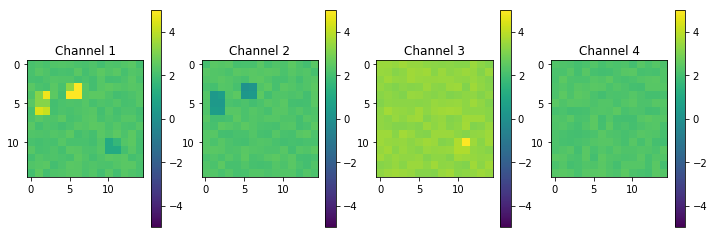

In [113]:
plt.figure(figsize=(12,4))
for i in range(inputs.shape[1]):
    plt.subplot(1,4,i+1)
    plt.imshow(inputs[0,i,:,:], interpolation='none', clim=[-5, 5])
    plt.colorbar()
    plt.title("Channel %s" % str(i+1))

In [114]:
# x = inputs.astype(np.float)
# # for i in range(x.shape[1]):
# #     mean = np.mean(x[0,i,:,:]) 
# #     std = np.std(x[0,i,:,:])
# #     x[0,i,:,:] -= mean
# #     x[0,i,:,:] /= std
# print x.min(), x.mean(), x.max()

def generate_ratios(inputs):
    # Generate channels ratios:
    in_shape = inputs.shape
    out_shape = list(inputs.shape)
    out_shape[1] *= (out_shape[1] - 1)
    outputs = np.zeros(out_shape)
    for k in range(out_shape[0]):
        for i in range(in_shape[1]):
            vals = range(in_shape[1])
            vals.remove(i)
            for j, v in enumerate(vals):
                outputs[k,i*(in_shape[1]-1) + j,:,:] = inputs[k,i,:,:] / inputs[k,v,:,:]
    return outputs

# Generate ratios : 1/2, 1/3, 1/4, 2/1, 2/3, 2/4, 3/1, 3/2, 3/4, 4/1, 4/2, 4/3
x = generate_ratios(inputs)
x.shape

(1L, 12L, 15L, 15L)

In [115]:
# y = np.random.rand(batch_size, n_classes, input_height, input_width)
# print y.min(), y.max()

y = np.zeros((1,2,input_height, input_width), dtype=np.uint8)
y[0,0,3:5,5:7] = 1
y[0,0,4:7,1:3] = 1
y[0,1,10:12,10:12] = 1

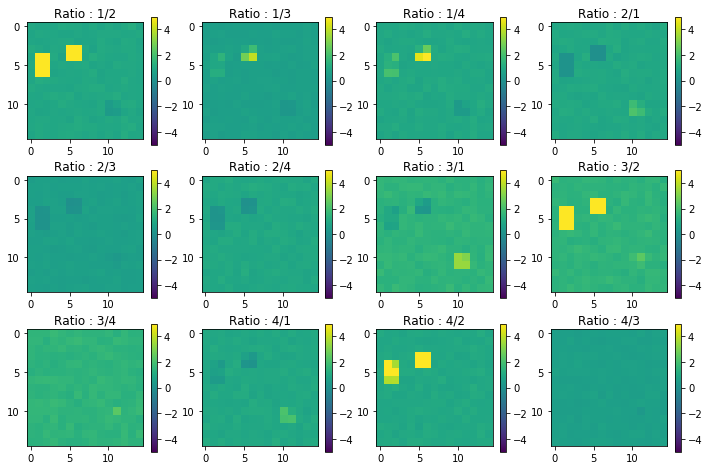

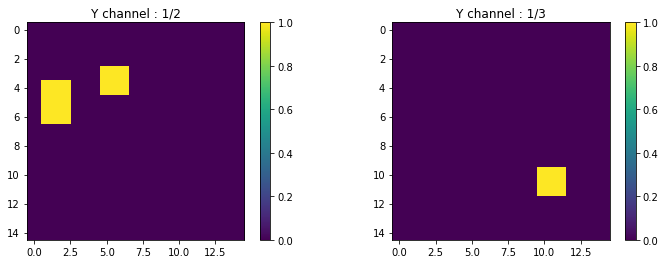

In [117]:
plt.figure(figsize=(12,8))
ratios = ["1/2", "1/3", "1/4", "2/1", "2/3", "2/4", "3/1", "3/2", "3/4", "4/1", "4/2", "4/3"]
for i in range(x.shape[1]):
    plt.subplot(3,4,i+1)
    plt.imshow(x[0,i,:,:], interpolation='none', clim=[-5, 5])
    plt.colorbar()
    plt.title("Ratio : %s" % ratios[i])

plt.figure(figsize=(12,4))
for i in range(y.shape[1]):
    plt.subplot(1,y.shape[1],i+1)
    plt.imshow(y[0,i,:,:], interpolation='none', clim=[0, 1])
    plt.colorbar()
    plt.title("Y channel : %s" % ratios[i])

In [138]:
batch_size=1
hist = model.fit(x, y, nb_epoch=10, batch_size=batch_size, verbose=2)

Epoch 1/10
0s - loss: 0.0050 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 2/10
0s - loss: 0.0048 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 3/10
0s - loss: 0.0047 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 4/10
0s - loss: 0.0046 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 5/10
0s - loss: 0.0045 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 6/10
0s - loss: 0.0044 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 7/10
0s - loss: 0.0043 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 8/10
0s - loss: 0.0042 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 9/10
0s - loss: 0.0041 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000
Epoch 10/10
0s - loss: 0.0040 - recall: 1.0000 - precision: 1.0000 - acc: 1.0000


In [139]:
layer = model.get_layer(index=1)
print layer.weights
w1 = layer.W.eval()
b1 = layer.b.eval()
print layer.W.eval()[:,:,0,0], layer.b.eval()

layer = model.get_layer(index=2)
print layer.weights
w2 = layer.W.eval()
b2 = layer.b.eval()
print layer.W.eval()[:,:,0,0], layer.b.eval()

# layer = model.get_layer(index=5)
# print layer.weights
# w3 = layer.W.eval()
# b3 = layer.b.eval()
# print layer.W.eval()[:,:,:,:], layer.b.eval()

[convolution2d_9_W, convolution2d_9_b]
CudaNdarray([[-0.05066311  0.65894705 -0.36301449  1.14658415  0.77737588  0.57277352
   1.03790176  0.45384523  0.1276319   0.15524678  0.58727586  0.49381015]
 [-0.72863477  0.24261604 -0.20585243 -0.0028874  -0.16272065 -0.30643761
  -0.57769203  0.27397671 -0.36833152  0.12237346  0.39090186  0.13601476]
 [ 0.57180673  0.94765079  1.38175011 -0.18948671  1.51749849  1.23686802
  -0.60157228  0.03564406  0.64687258  0.20831227  1.13406944  0.4657374 ]
 [-0.00329404 -0.0832574  -0.48632288  0.03666219  0.19280156  0.34597307
   0.006129    0.09633657 -0.84785724  0.04190066 -0.05392664 -0.76370943]
 [ 1.16877949  1.09348047  1.21880269 -0.41682348  0.24712504 -0.90847021
  -0.68091267  0.07604885  0.0346519  -0.2438046   0.4040691   1.36152411]
 [-0.56276464 -0.2462098  -0.05901194 -0.48513636 -0.74320346 -0.71090245
  -0.428161   -0.18600361 -0.26844797 -0.09865705  0.62560838  0.24214497]
 [ 0.82589281 -0.24448669  0.73832333 -0.35731363 -0.24

In [1569]:
t1 = np.sum(w1 * x, axis=1) + b1
t1[t1 < 0] = 0.0
t2 = np.sum(w2 * 1.0/x, axis=1) + b2
t2[t2 < 0] = 0.0

In [1043]:
t3 = (t1 * t2).reshape((1,) + t1.shape)
t3[t3 < 0] = 0.0

In [1044]:
t3.shape, w3.shape

((1, 1, 15, 15), (1, 1, 1, 1))

In [1045]:
out = t3 * w3 + b3
out = K.sigmoid(out).eval()
out.shape, out.min(), out.max()

((1, 1, 15, 15), 0.12985255664113604, 1.0)

In [976]:
w1[:] = 0.0
w1[0,0,:,:] = 1.0
w2[:] = 0.0
w2[0,1,:,:] = 1.0
w3[:] = 1.0

layer = model.get_layer(index=2)
layer.set_weights(weights=[w1, np.array([0.0])])
layer = model.get_layer(index=3)
layer.set_weights(weights=[w2, np.array([0.0])])
layer = model.get_layer(index=5)
layer.set_weights(weights=[w3, np.array([-3.0])])

In [141]:
y_pred = model.predict(x)
y_pred.shape, y_pred.min(), y_pred.max()

((1L, 2L, 15L, 15L), 0.0, 1.0)

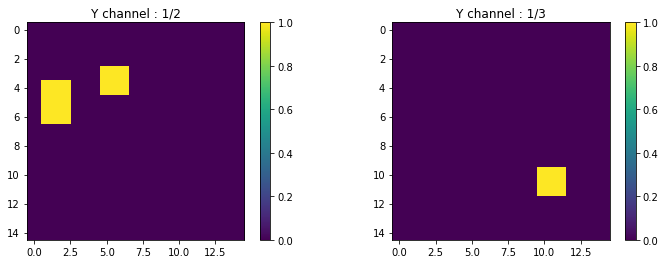

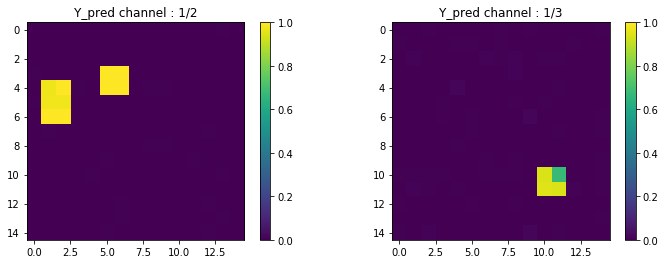

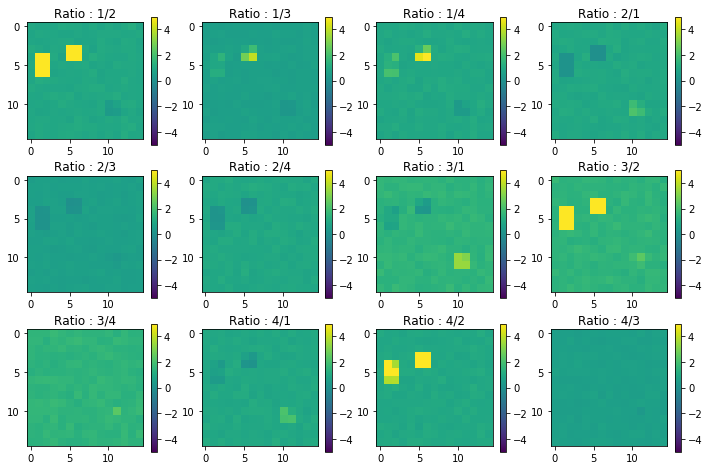

In [142]:
plt.figure(figsize=(12,4))
for i in range(y.shape[1]):
    plt.subplot(1,y.shape[1],i+1)
    plt.imshow(y[0,i,:,:], interpolation='none', clim=[0, 1])
    plt.colorbar()
    plt.title("Y channel : %s" % ratios[i])

plt.figure(figsize=(12,4))
for i in range(y_pred.shape[1]):
    plt.subplot(1,y_pred.shape[1],i+1)
    plt.imshow(y_pred[0,i,:,:], interpolation='none', clim=[0, 1])
    plt.colorbar()
    plt.title("Y_pred channel : %s" % ratios[i])
    
plt.figure(figsize=(12,8))
ratios = ["1/2", "1/3", "1/4", "2/1", "2/3", "2/4", "3/1", "3/2", "3/4", "4/1", "4/2", "4/3"]
for i in range(x.shape[1]):
    plt.subplot(3,4,i+1)
    plt.imshow(x[0,i,:,:], interpolation='none', clim=[-5, 5])
    plt.colorbar()
    plt.title("Ratio : %s" % ratios[i])


In [ ]:
# inputs = 

What is Convolution3D

In [16]:
from keras.layers import Convolution3D, Input, Reshape
from keras.optimizers import Adam

In [7]:
help(Convolution3D)

Help on class Convolution3D in module keras.layers.convolutional:

class Convolution3D(keras.engine.topology.Layer)
 |  Convolution operator for filtering windows of three-dimensional inputs.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(3, 10, 128, 128)` for 10 frames of 128x128 RGB pictures.
 |  
 |  # Arguments
 |      nb_filter: Number of convolution filters to use.
 |      kernel_dim1: Length of the first dimension in the convolution kernel.
 |      kernel_dim2: Length of the second dimension in the convolution kernel.
 |      kernel_dim3: Length of the third dimension in the convolution kernel.
 |      init: name of initialization function for the weights of the layer
 |          (see [initializations](../initializations.md)), or alternatively,
 |          Theano function to use for weights initialization.
 |          This parameter is o

In [48]:
n_filters_0 = 1
n_classes = 2
input_height = 10
input_width = 10
n_channels = 3
size=3

inputs = Input((1, n_channels, input_height, input_width))
x = inputs
x = Convolution3D(n_filters_0, size, size, size, init='one', activation='relu')(x)
outputs = x

model = Model(input=inputs, output=outputs)

In [49]:
X = np.ones((1, 1, n_channels, input_height, input_width))
for i in range(1,n_channels):
    X[0, 0, i, :, :] = i+1

In [50]:
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['recall', 'precision', 'accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 1, 3, 10, 10)  0                                            
____________________________________________________________________________________________________
convolution3d_8 (Convolution3D)  (None, 1, 1, 8, 8)    28          input_8[0][0]                    
Total params: 28
Trainable params: 28
Non-trainable params: 0
____________________________________________________________________________________________________


In [51]:
layer = model.get_layer(index=1)
print layer.W.eval(), layer.b.eval()

[[[[[ 1.  1.  1.]
    [ 1.  1.  1.]
    [ 1.  1.  1.]]

   [[ 1.  1.  1.]
    [ 1.  1.  1.]
    [ 1.  1.  1.]]

   [[ 1.  1.  1.]
    [ 1.  1.  1.]
    [ 1.  1.  1.]]]]] [ 0.]


In [52]:
Y_pred = model.predict(X)

In [53]:
X.shape, Y_pred.shape

((1, 1, 3, 10, 10), (1, 1, 1, 8, 8))

In [54]:
print X[0,0,:,0,0]
print Y_pred[0,0,0,:,:]

[ 1.  2.  3.]
[[ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.]]


In [57]:
size**2 * (np.sum(X[0,0,:,0,0]))

54.0

In [1471]:
def generate_ratios(inputs):
    # Generate channels ratios:
    in_shape = inputs.shape
    out_shape = list(inputs.shape)
    out_shape[1] *= (out_shape[1] - 1)
    outputs = np.zeros(out_shape)
    for k in range(out_shape[0]):
        for i in range(in_shape[1]):
            vals = range(in_shape[1])
            vals.remove(i)
            for j, v in enumerate(vals):
                outputs[k,i*(in_shape[1]-1) + j,:,:] = inputs[k,i,:,:] / inputs[k,v,:,:]
    return outputs

In [1472]:
x=np.zeros((1,4,5,5))
x[0,0,:,:] = 1.0
x[0,1,:,:] = 2.0
x[0,2,:,:] = 3.0
x[0,3,:,:] = 4.0

In [1473]:
xx = generate_ratios(x)
xx.shape

(1, 12, 5, 5)

In [1480]:
xx[0,6,:,:]

array([[ 3.,  3.,  3.,  3.,  3.],
       [ 3.,  3.,  3.,  3.,  3.],
       [ 3.,  3.,  3.,  3.,  3.],
       [ 3.,  3.,  3.,  3.,  3.],
       [ 3.,  3.,  3.,  3.,  3.]])

In [1415]:
import theano
from theano import tensor as T
from theano.

X = K.variable(x)
in_shape = K.shape(X)
in_shape.eval(), type(X), type(in_shape)

(array([1, 4, 5, 5]),
 theano.tensor.sharedvar.TensorSharedVariable,
 theano.tensor.var.TensorVariable)

In [1421]:
out_shape = T.set_subtensor(in_shape[1], in_shape[1]*(in_shape[1]-1))

In [1424]:
results,updates = theano.scan(
    lambda i,j : X[:,i,:,:] / X[:,j,:,:],
    sequences=[T.arange(X.shape[1]), T.arange(X.shape[1])+1],
    outputs_info=None
)

In [1425]:
mix_channels = theano.function(inputs=[X], outputs=results)

TypeError: Cannot use a shared variable (<TensorType(float32, 4D)>) as explicit input. Consider substituting a non-shared variable via the `givens` parameter

In [1420]:
np.asarray(0., dtype=theano.config.floatX)

array(0.0, dtype=float32)

In [1406]:
# out_shape = T.set_subtensor(in_shape[1], in_shape[1]*(in_shape[1]-1))
# out_shape.eval()
# XX = T.zeros(out_shape)

# X = T.matrix("X")
# results, updates = theano.scan(lambda i, j, t_f: T.cast(X[i, j] + t_f, floatX),
#                   sequences=[T.arange(X.shape[0]), T.arange(X.shape[1])],
#                   outputs_info=np.asarray(0., dtype=floatX))
# result = results[-1]
# compute_trace = theano.function(inputs=[X], outputs=result)

# # test value
# x = np.eye(5, dtype=theano.config.floatX)
# x[0] = np.arange(5, dtype=theano.config.floatX)
# print(compute_trace(x))


TypeError: TensorType does not support iteration. Maybe you are using builtin.sum instead of theano.tensor.sum? (Maybe .max?)

In [20]:
a = 2*K.ones((3, 5, 10,10))
b = 3*K.ones((3, 5, 10,10))

In [21]:
c = K.concatenate([a, b], axis=1)

In [22]:
K.shape(c).eval()

array([ 3, 10, 10, 10])

In [231]:
b = K.cast(K.greater(a, 0.5),'float32')

In [232]:
b.eval()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [233]:
c = a * b

In [234]:
c.eval()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.55000001,  0.60000002,  0.64999998,  0.69999999,
        0.75      ,  0.80000001,  0.85000002,  0.89999998,  0.94999999], dtype=float32)